# Building a MovieLens Recommender System

<img src="https://recommender-tutorial.s3-us-west-2.amazonaws.com/images/movielens.png" width='25%' align='right'/>



### What is MovieLens?

MovieLens is a recommender system that was developed by GroupLens, a computer science research lab at the University of Minnesota. It recommends movies to its users based on their movie ratings. It is also a dataset that is widely used in research and teaching contexts.

###  Outline

This is broken down into 4 steps:

1. Importing the dependencies
1. Loading the data
1. Exploratory data analysis
1. Multi-Layer Perceptron (MLP)

### Step 1: Import the dependencies :

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder

### Step 2: Load Data

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marwaelkamil","key":"ad3d92e3b102fc7ccb3c93df264dcb66"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d grouplens/movielens-20m-dataset

 96% 188M/195M [00:02<00:00, 88.1MB/s]
100% 195M/195M [00:02<00:00, 89.5MB/s]


In [ ]:
!unzip movielens-20m-dataset.zip


Archive:  movielens-20m-dataset.zip
  inflating: genome_scores.csv       
  inflating: genome_tags.csv         
  inflating: link.csv                
  inflating: movie.csv               
  inflating: rating.csv              
  inflating: tag.csv                 


In [ ]:
ratings = pd.read_csv('rating.csv')

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [ ]:
movies = pd.read_csv('movie.csv')

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Step 3: Exploratory Data Analysis

In [ ]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 20000263
Number of unique movieId's: 26744
Number of unique users: 138493
Average number of ratings per user: 144.41
Average number of ratings per movie: 747.84


### What is the distribution of movie ratings?

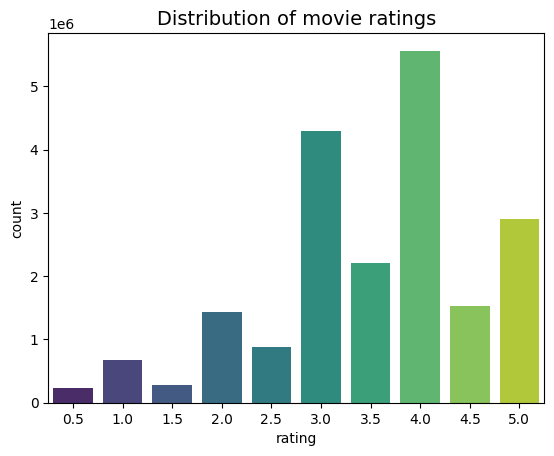

In [ ]:
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [ ]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.53.
Mean rating per user: 3.63.


### Which movies are most frequently rated?

In [ ]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

Pulp Fiction (1994)                          67310
Forrest Gump (1994)                          66172
Shawshank Redemption, The (1994)             63366
Silence of the Lambs, The (1991)             63299
Jurassic Park (1993)                         59715
Star Wars: Episode IV - A New Hope (1977)    54502
Braveheart (1995)                            53769
Terminator 2: Judgment Day (1991)            52244
Matrix, The (1999)                           51334
Schindler's List (1993)                      50054
Name: title, dtype: int64

Forrest Gump, Shawshank Redemption, and Pulp Fiction have the most ratings.

### What are the lowest and highest rated movies?

Which movie has the lowest and highest average rating?

In [ ]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId']==lowest_rated]

,movieId,title,genres
5706,5805,Besotted (2001),Drama


`Besotted` has the lowest average rating.

In [ ]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
9007,26718,Life On A String (Bian chang Bian Zou) (1991),Adventure|Drama|Fantasy|Musical


How many ratings does `Life On A String (Bian chang Bian Zou) (1991)` have?

### A Glimpse at Movie Genres

The movies dataset needs to be cleaned in two ways:

- `genres` is expressed as a string with a pipe `|` separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.
- `title` currently has (year) appended at the end. We will extract year from each title string and create a new column for it.

In [ ]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


**How many movie genres are there?**

In [ ]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Adventure': 2329,
         'Animation': 1027,
         'Children': 1139,
         'Comedy': 8374,
         'Fantasy': 1412,
         'Romance': 4127,
         'Drama': 13344,
         'Action': 3520,
         'Crime': 2939,
         'Thriller': 4178,
         'Horror': 2611,
         'Mystery': 1514,
         'Sci-Fi': 1743,
         'IMAX': 196,
         'Documentary': 2471,
         'War': 1194,
         'Musical': 1036,
         'Western': 676,
         'Film-Noir': 330,
         '(no genres listed)': 246})

In [ ]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 13344), ('Comedy', 8374), ('Thriller', 4178), ('Romance', 4127), ('Action', 3520)]


The top 5 genres are: `Drama`, `Comedy`, `Thriller`, `Action` and `Romance`.

Let's also visualize genres popularity with a barplot.

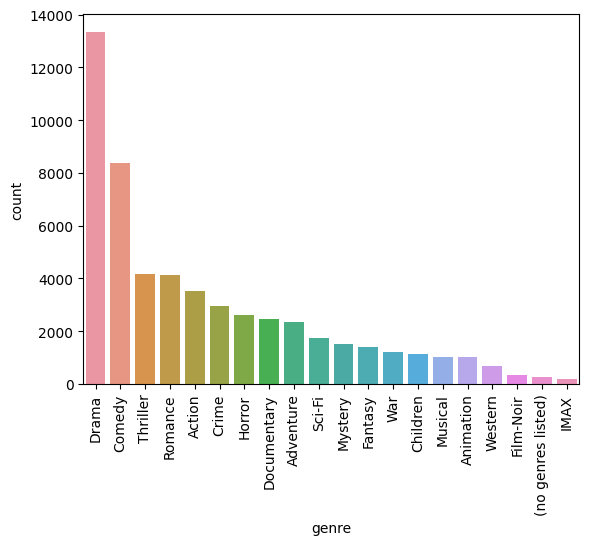

In [ ]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()

In [ ]:
duplicate = movies.duplicated(subset=['movieId', 'title']).sum()# check for duplicate rows
duplicate

0

In [ ]:
missing_values_total = movies.isnull().sum()#missing values
missing_values_total

movieId    0
title      0
genres     0
dtype: int64

## Step 4 : Multi-Layer Perceptron (MLP)

In [ ]:
# Read the dataset
df = pd.read_csv('rating.csv')

# Assuming the file has columns 'userId', 'movieId', and 'rating'
print(df.head())


   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40


In [ ]:
df.shape

(20000263, 4)

In [ ]:
df.columns
df = df.iloc[:300000,:]


Encode User and Movie IDs:

User IDs and Movie IDs are usually categorical in nature and need to be converted into a numerical format that a neural network can work with. We'll use Label Encoding to convert these categorical IDs to numerical IDs.

In [ ]:
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

# Fit and transform the user and movie IDs
df['user'] = user_encoder.fit_transform(df['userId'])
df['movie'] = movie_encoder.fit_transform(df['movieId'])

Normalize Ratings:

If the ratings are not already between 0 and 1, we should normalize them as neural networks usually perform better with normalized input data. We'll use Min-Max normalization which scales the ratings to be within the [0, 1] range.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the ratings
df['rating'] = scaler.fit_transform(df[['rating']].values.astype(float))


Split Dataset into Training and Testing Sets:

Before training our model, it’s important to split our dataset into training and testing sets. This way, we can train our model on one portion of the data and test its performance on unseen data.

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the data
X = df[['user', 'movie']]
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
X_test.iloc[:,1].shape

(60000,)

 Create the MLP Model

In [ ]:
# Assuming df is your pandas DataFrame after preprocessing
users = df.userId.unique().tolist()
movies = df.movieId.unique().tolist()
num_users = df['user'].nunique()
num_movies = df['movie'].nunique()
embedding_size = 50

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.regularizers import l2

# Regularization strength
l2_reg = 0.001

# User Input and Embedding Layer
user_input = Input(shape=(1,), name='user_input')
user_embedding = Embedding(num_users, embedding_size, name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_user')(user_embedding)

# Movie Input and Embedding Layer
movie_input = Input(shape=(1,), name='movie_input')
movie_embedding = Embedding(num_movies, embedding_size, name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movie')(movie_embedding)

# Concatenate the flattened embedding layers
concat = Concatenate()([user_vec, movie_vec])

# Fully Connected Layers with L2 Regularization
dense_1 = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(concat)
output = Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))(dense_1)  # Sigmoid because the ratings are normalized between 0 and 1

# Create and compile the model
model = Model(inputs=[user_input, movie_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Model Summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 movie_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 50)                102700    ['user_input[0][0]']          
                                                                                                  
 movie_embedding (Embedding  (None, 1, 50)                552100    ['movie_input[0][0]']         
 )                                                                                            

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopper = EarlyStopping(
    monitor='val_loss',     # Monitor the validation loss
    min_delta=0.001,        # Minimum change to qualify as an improvement
    patience=2,             # How many epochs to wait for improvement
    verbose=1,              # Logging level
    mode='min',             # The training will stop when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Fit the model with the early stopping callback
history = model.fit(
    [X_train['user'], X_train['movie']], y_train,
    epochs=10,  # Set a high number since training will stop once early stopping condition is met
    batch_size=32,
    shuffle=True,
    validation_data=([X_test['user'], X_test['movie']], y_test),
    callbacks=[]
)


Epoch 1/10
7500/7500 [==============================] - 79s 11ms/step - loss: 0.0374 - val_loss: 0.0395
Epoch 2/10
7500/7500 [==============================] - 79s 11ms/step - loss: 0.0370 - val_loss: 0.0396
Epoch 3/10
7500/7500 [==============================] - 82s 11ms/step - loss: 0.0368 - val_loss: 0.0393
Epoch 4/10
7500/7500 [==============================] - 81s 11ms/step - loss: 0.0366 - val_loss: 0.0395
Epoch 5/10
7500/7500 [==============================] - 77s 10ms/step - loss: 0.0365 - val_loss: 0.0396
Epoch 6/10
7500/7500 [==============================] - 77s 10ms/step - loss: 0.0364 - val_loss: 0.0392
Epoch 7/10
7500/7500 [==============================] - 80s 11ms/step - loss: 0.0363 - val_loss: 0.0391
Epoch 8/10
7500/7500 [==============================] - 79s 11ms/step - loss: 0.0362 - val_loss: 0.0396
Epoch 9/10
7500/7500 [==============================] - 78s 10ms/step - loss: 0.0361 - val_loss: 0.0392
Epoch 10/10
7500/7500 [==============================] - 80s 11m

In [ ]:
model.evaluate([X_test['user'], X_test['movie']], y_test)


1875/1875 [==============================] - 3s 1ms/step - loss: 0.0392


0.039236634969711304

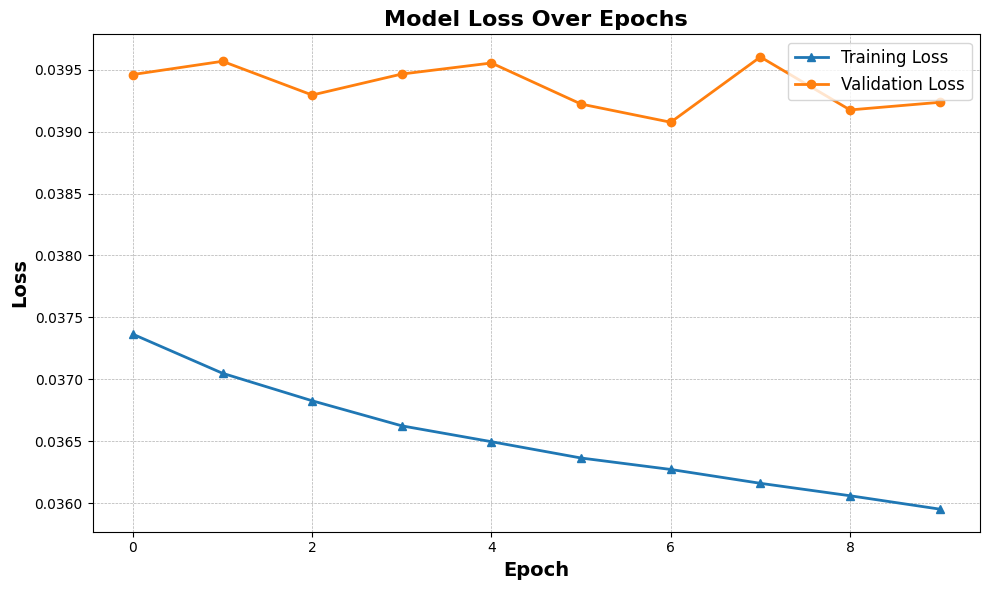

In [ ]:
import matplotlib.pyplot as plt

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Plot training and validation loss with different styles and markers
plt.plot(history.history["loss"], '^-', label="Training Loss", linewidth=2)
plt.plot(history.history["val_loss"], 'o-', label="Validation Loss", linewidth=2)

# Title and label formatting
plt.title("Model Loss Over Epochs", fontsize=16, fontweight='bold')
plt.ylabel("Loss", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=14, fontweight='bold')

# Set the limits for the axes if necessary
# plt.xlim(0, len(history.history["loss"]))
# plt.ylim(0, max(max(history.history["loss"]), max(history.history["val_loss"])))

# Add grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a legend
plt.legend(loc="upper right", fontsize=12, frameon=True)

# Use tight layout to optimize spacing of axes and titles within the plot
plt.tight_layout()


# Show the plot with all enhancements
plt.show()


If the ratings are normalized between 0 and 1, an MSE of 0.0392 could be considered quite good, as it indicates a relatively small average squared deviation from the true ratings

In [ ]:
model.save_weights('model_weights.h5')

In [ ]:
movies_df = pd.read_csv('movie.csv')


In [ ]:
movies_df.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [ ]:
# Randomly sample one user ID from the DataFrame
user_id = df.userId.sample(1).iloc[0]

# Get a list of movie IDs that this user has already watched
# df.iloc[:,1] should be the column that contains movie IDs in the ratings DataFrame
watched_movs = df[df.userId == user_id].iloc[:,1]

# Find all movie IDs in the movies DataFrame that are not in the watched movies list
# This assumes `movies_df` is a DataFrame that contains all possible movies with a column 'movieId'
not_watched_movs = movies_df[~movies_df.movieId.isin(watched_movs.values)].movieId

# Display the list of not watched movie IDs
not_watched_movs


1             2
2             3
3             4
4             5
6             7
          ...  
27273    131254
27274    131256
27275    131258
27276    131260
27277    131262
Name: movieId, Length: 26621, dtype: int64

In [ ]:
# Create a dictionary to map each movie to a unique encoded number
# 'movies' should be a list of all unique movie IDs
movie2movie_encoded = {x: i for i, x in enumerate(movies)}

# Create a reverse dictionary to decode the encoded number back to the original movie ID
movie_encoded2movie = {i: x for i, x in enumerate(movies)}

# Create a dictionary to map each user to a unique encoded number
# 'users' should be a list of all unique user IDs
user2user_encoded = {x: i for i, x in enumerate(users)}

# Create a reverse dictionary to decode the encoded number back to the original user ID
user_encoded2user = {i: x for i, x in enumerate(users)}

# Filter the not watched movies to include only movies that have an encoding
not_watched_movs = list(
    set(not_watched_movs).intersection(set(movie2movie_encoded.keys()))
)

# Transform the list of not watched movies into a list of lists where each inner list
# contains the encoded ID of a movie
not_watched_movs = [[movie2movie_encoded.get(x)] for x in not_watched_movs]


The purpose of this encoding is usually to convert categorical data into a numerical format that a machine learning algorithm can process since most algorithms require numerical input. This encoding step is essential for handling categorical variables like movie and user IDs in recommendation systems.

In [ ]:
# Obtain the encoded value for the user_id from the user2user_encoded dictionary.
# The .get() method returns the value for the given key if it exists in the dictionary.
user_encoder = user2user_encoded.get(user_id)

# Display the encoded user ID
user_encoder


57

In [ ]:

# Create an array of the encoded user ID repeated for the number of movies not watched
# and horizontally stack it with the encoded movie IDs to create user-movie pairs
user_movie_array = np.hstack(
    ([[user_encoder]] * len(not_watched_movs), not_watched_movs))

# Display the resulting array of user-movie pairs
user_movie_array


array([[  57,    0],
       [  57,  175],
       [  57, 1994],
       ...,
       [  57, 1027],
       [  57, 5391],
       [  57, 6532]])

In [ ]:
# Predict the ratings for each user-movie pair using the trained model
# user_movie_array[:,0] is the array of user IDs, and user_movie_array[:,1] is the array of movie IDs
ratings = model.predict([user_movie_array[:,0], user_movie_array[:,1]]).flatten()
print(ratings)

# Define a function to get the top K ratings
def get_top_ratings(ratings, k=5):
    # Get the indices of the top K ratings
    top_ratings_idx = ratings.argsort()[-k:][::-1]
    # Convert these indices to the original movie IDs using the movie_encoded2movie mapping
    top_ratings = [movie_encoded2movie.get(x) for x in top_ratings_idx]
    return top_ratings

# Print the top K recommendations for the user
print(get_top_ratings(ratings))


325/325 [==============================] - 1s 4ms/step
[0.8217849  0.59559953 0.7397059  ... 0.77348626 0.7303056  0.8037866 ]
[63992, 7958, 5552, 2479, 3081]


In [ ]:
top_movies_ids = get_top_ratings(ratings,5)
top_movies_ids

[63992, 7958, 5552, 2479, 3081]

In [ ]:
# Define a function to create a header divider with title
def print_header(title):
    print("\n" + "\u2550" * (len(title) + 4))
    print(f"\u2554 {' ' + title + ' ':^34s} \u2557")
    print("\u2550" * (len(title) + 4))

# Define a function to create a section divider
def print_section_divider():
    print("\u2551" + "-" * 34 + "\u2551")

# Start printing the recommendations
print_header(f"Showing recommendations for user: {user_id}")

# Ensure the user has rated some movies
if user_id in df.userId.unique():
    print("\n\U0001F4D6 Movies with high ratings from user \U0001F4D6")
    print_section_divider()

    # Get the top-rated movies watched by the user
    top_watched_movies = df[df.userId == user_id].sort_values(by='rating', ascending=False).movieId.head(5)
    top_watched_movies_info = movies_df[movies_df.movieId.isin(top_watched_movies.values)]

    # Print the user's top-rated movies
    for element in top_watched_movies_info.itertuples():
        print(f"\u2551 {element.title} - {element.genres}")
    print_section_divider()
else:
    print("\u2551 No ratings available for this user. \u2551")
    print_section_divider()

# Print top movie recommendations
print_header("Top 5 movie recommendations")

# Make sure there are recommendations to display
if top_movies_ids:
    # Get movie information for the recommended movie IDs
    top_movies = movies_df[movies_df.movieId.isin(top_movies_ids)]

    # Print the recommended movies
    for element in top_movies.itertuples():
        print(f"\u2551 {element.title} - {element.genres}")
    print_section_divider()
else:
    print("\u2551 No recommendations available. \u2551")
    print_section_divider()



════════════════════════════════════════
╔  Showing recommendations for user: 58  ╗
════════════════════════════════════════

📖 Movies with high ratings from user 📖
║----------------------------------║
║ Toy Story (1995) - Adventure|Animation|Children|Comedy|Fantasy
║ On the Waterfront (1954) - Crime|Drama
║ French Connection, The (1971) - Action|Crime|Thriller
║ Rocky (1976) - Drama
║ Seven Samurai (Shichinin no samurai) (1954) - Action|Adventure|Drama
║----------------------------------║

═══════════════════════════════
╔    Top 5 movie recommendations     ╗
═══════════════════════════════
║ Gloria (1999) - Drama|Thriller
║ Sleepy Hollow (1999) - Fantasy|Horror|Mystery|Romance
║ Revenge of Frankenstein, The (1958) - Drama|Horror|Sci-Fi
║ Bloody Mama (1970) - Crime|Drama
║ Twilight (2008) - Drama|Fantasy|Romance|Thriller
║----------------------------------║




The first section, "Movies with high ratings from user," lists movies that the user has already watched and rated highly. This is useful for understanding the user's preferences and verifying that the recommendation algorithm is suggesting movies that align with those preferences.

The second section, "Top 5 movie recommendations," provides a list of movies that the user has not yet watched but might enjoy, based on the model's predictions. Each movie is listed with its title and associated genres, which can help the user decide if they're interested in watching them.

This output indicates that the recommendation system is functioning as intended: it takes into account the user's past preferences to suggest new content that the user might find appealing.

In [ ]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
